In [9]:
import json
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt

In [10]:
# Place files in trace folder, then write them here
filenames = ["trace/same-MsgTraces_W5_load-50p_0.tr", "trace/different-MsgTraces_W5_load-50p_0.tr"]

In [11]:
# Constants
figsize = (10,6)
pktPayloadSize = 1460 # Bytes
hdrSize = 40 #Bytes
torBw = 10e9 # bps
coreBw = 40e9 # bps

oneWayDel = 1.0e-6 \
         + (pktPayloadSize+hdrSize)*8*(2/torBw + 2/coreBw)
baseRtt = oneWayDel \
         + 1.0e-6 + 64*8*(2/torBw + 2/coreBw)

bdpPkts = 7

workloadName = '_W5'
workloadSource = 'DCTCP'
networkLoad = 0.5
simName = workloadName + '_load-' + str(int(networkLoad*100)) + 'p'
numSim = 1
folder = 'analysis/'
file1 = "same-MsgTraces_W5_load-50p_0.tr"
file2 = "different-MsgTraces_W5_load-50p_0.tr"

plotQueueFigures = False
saturationTime = 3.1

In [12]:
def removeKey(d, key):
    r = dict(d)
    del r[key]
    return r

In [13]:
def getPctl(a, p):
    i = int(len(a) * p)
    return a[i]

In [14]:
def processFile(filename, do_print=True):
    msgStartEntryDict = {}
    msgCompletionTimesDict = {}
    allMsgSizes = []

    for i in range(numSim):
        with open(filename,'r') as f:
            for line in f:
                msgLog = line.split()

                time = float(msgLog[1])*1e-9        # in seconds
                msgSize = int(msgLog[2])#//1462*1462 # in bytes
                sender = msgLog[3]                  # ip:port
                receiver = msgLog[4]                # ip:port
                txMsgId = int(msgLog[5])

                key = (sender, receiver, txMsgId, i)

                if (msgLog[0]=='+'):
                    if (key in msgStartEntryDict):
                        msgStartEntryDict[key].append(time)
                    else:
                        msgStartEntryDict[key] = [time]

                elif (msgLog[0] =='-'):
                    if (key in msgStartEntryDict):
                        startTime = msgStartEntryDict[key].pop()
                        if (len(msgStartEntryDict[key]) <= 0):
                            msgStartEntryDict = removeKey(msgStartEntryDict, key)

                        if(startTime < saturationTime):
                            continue
                    
                        if (msgSize in msgCompletionTimesDict):
                            msgCompletionTimesDict[msgSize].append(time-startTime)
                        else:
                            msgCompletionTimesDict[msgSize] = [time-startTime]
                        allMsgSizes.append(msgSize)
                    else:
                        print('ERROR: Start entry of message (' \
                            + sender + ' > ' + receiver + ', ' + str(txMsgId) \
                            + ') not found!')
    allMsgSizes = np.array(allMsgSizes)
    msgSizePercentiles = stats.rankdata(allMsgSizes, 'max')/len(allMsgSizes)*100

    #########################3
    i = 0
    for msgKey, msgStartTimes in msgStartEntryDict.items():
    #     print(msgKey, ' : ', msgStartTimes)
        i += len(msgStartTimes)
    if (do_print):
        print ('Number of uncompleted messages: ' + str(i))


    #########################3
    if (do_print):
        print('Number of distinct message sizes: ' + str(len(msgCompletionTimesDict)))

    cntMultMeasures = 0
    numMsgs = 0
    nonFullPacketMsgSizes = []
    for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
        
        if (len(msgCompletionTimes)>1):
            cntMultMeasures += 1
        
        numMsgs += len(msgCompletionTimes)
        
        if (msgSize%pktPayloadSize != 0):
            nonFullPacketMsgSizes.append((msgSize,msgSize%pktPayloadSize))
        
    if (do_print):
        print('Number of distinct message sizes that '+'have multiple measurements: ' + str(cntMultMeasures))   
        print('Number of distinct messages: ' + str(numMsgs)) 

    # if (nonFullPacketMsgSizes):
    #     print('Non-Full Packet Message Sizes: ', nonFullPacketMsgSizes)

    ###########33   
    return msgCompletionTimesDict, msgSizePercentiles, allMsgSizes
        

In [15]:
def plot_data(msgCompletionTimesDict, msgSizePercentiles, allMsgSizes, plot_orig_results=False):
    SimMsgSizes = []
    SimP50CompletionTimes = []
    SimP99CompletionTimes = []
    SimBaseCompletionTimes = []
    SimP50SlowDowns = []
    SimP99SlowDowns = []

    for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
        # Ignore messages that have less than 10 measurements
        SimMsgSizes.append(msgSize)
        
        # Calculate completion times
        times = np.array(msgCompletionTimes)
        p50CompletionTime = np.percentile(times,50)
        SimP50CompletionTimes.append(p50CompletionTime)
        p99CompletionTime = np.percentile(times,99)
        SimP99CompletionTimes.append(p99CompletionTime)
        
        # Total bytes of message including its header
        totBytes = msgSize + math.ceil(msgSize / pktPayloadSize) * (hdrSize) 

        # Theoretical fastest completion time (bytes sent divided by link bandwidth)
        baseCompletionTime = totBytes * 8 / torBw;

        # Add the one-way delay for the first packet
        if (msgSize > bdpPkts * pktPayloadSize):
            baseCompletionTime += oneWayDel #baseRtt
        else:
            baseCompletionTime += oneWayDel
        
        # Add the one-way delay for the remaining packets
        SimBaseCompletionTimes.append(baseCompletionTime)
        
        # Calculate slowdowns
        SimP50SlowDowns.append(p50CompletionTime / baseCompletionTime)
        SimP99SlowDowns.append(p99CompletionTime / baseCompletionTime)
        
    zipData = sorted(zip(SimMsgSizes,
                        SimP50CompletionTimes,
                        SimP99CompletionTimes,
                        SimBaseCompletionTimes,
                        SimP50SlowDowns,
                        SimP99SlowDowns))

    SimMsgSizes = np.array([x for x,_,_,_,_,_ in zipData])

    SimP50CompletionTimes = np.array([x for _,x,_,_,_,_ in zipData])
    SimP99CompletionTimes = np.array([x for _,_,x,_,_,_ in zipData])

    SimBaseCompletionTimes = np.array([x for _,_,_,x,_,_ in zipData])

    SimP50SlowDowns = np.array([x for _,_,_,_,x,_ in zipData])
    SimP99SlowDowns = np.array([x for _,_,_,_,_,x in zipData])


    ################################################
    x = [msgSizePercentiles[np.where(allMsgSizes == i)[0][0]] for i in SimMsgSizes]
    plt.step(x,SimP50SlowDowns, label='NS-3 50%', color='C0')
    plt.step(x,SimP99SlowDowns,label='NS-3 99%', color='C1')

    if (plot_orig_results):
        plt.step(origMsgSizeCumPercents,origP50SlowDowns, label='OMNet++ 50%',
                linestyle='--', color='C0')
        plt.step(pfabricMsgSizeCumPercents,pfabricP50SlowDowns, label='pFabric 50%',
                linestyle='--', color='C3')
        plt.step(origMsgSizeCumPercents,origP99SlowDowns, label='OMNet++ 99%',
                linestyle='--', color='C1')
        plt.step(pfabricMsgSizeCumPercents,pfabricP99SlowDowns, label='pFabric 99%',
                linestyle=':', color='C3')

    plt.ylabel('Slow Down')
    plt.xlabel('Message Size (Bytes)')
    plt.title('Homa Message Completion Slowdown for ' + \
            workloadSource + ' Workload with ' + \
            str(networkLoad*100) + '% Load')
    plt.legend(loc='upper left')

    xTickPercentiles = np.linspace(10, 100, 10)
    xticks = np.percentile(allMsgSizes,xTickPercentiles).astype(int) 
    plt.xticks(xTickPercentiles, xticks, rotation=45)

    plt.yscale('log')
    yticks = None
    if (networkLoad==0.5):
        yticks = [1,2,3,4,5,10,15]
        plt.ylim([1,15])
    elif (networkLoad==0.8):
        yticks = [1,2,3,4,5,10,20,30]
        plt.ylim([1,30])
    if (yticks):
        plt.yticks(yticks, yticks)

    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.tight_layout()

In [16]:
# import matplotlib.pyplot as plt
# import numpy as np
# import math

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_data_v2(msgCompletionTimesDict, msgSizePercentiles, allMsgSizes, filename, color, plot_orig_results=False, plot_smoothed_results=False):
    # Data preparation
    SimMsgSizes = []
    SimP50CompletionTimes = []
    SimP99CompletionTimes = []
    SimBaseCompletionTimes = []
    SimP50SlowDowns = []
    SimP99SlowDowns = []

    for msgSize, msgCompletionTimes in msgCompletionTimesDict.items():
        # Ignore messages that have less than 10 measurements
        SimMsgSizes.append(msgSize)
        
        # Calculate completion times
        times = np.array(msgCompletionTimes)
        p50CompletionTime = np.percentile(times,50)
        SimP50CompletionTimes.append(p50CompletionTime)
        p99CompletionTime = np.percentile(times,99)
        SimP99CompletionTimes.append(p99CompletionTime)
        
        # Total bytes of message including its header
        totBytes = msgSize + math.ceil(msgSize / pktPayloadSize) * (hdrSize) 

        # Theoretical fastest completion time (bytes sent divided by link bandwidth)
        baseCompletionTime = totBytes * 8 / torBw;

        # Add the one-way delay for the first packet
        if (msgSize > bdpPkts * pktPayloadSize):
            baseCompletionTime += oneWayDel #baseRtt
        else:
            baseCompletionTime += oneWayDel
        
        # Add the one-way delay for the remaining packets
        SimBaseCompletionTimes.append(baseCompletionTime)
        
        # Calculate slowdowns
        SimP50SlowDowns.append(p50CompletionTime / baseCompletionTime)
        SimP99SlowDowns.append(p99CompletionTime / baseCompletionTime)
        
    zipData = sorted(zip(SimMsgSizes,
                        SimP50CompletionTimes,
                        SimP99CompletionTimes,
                        SimBaseCompletionTimes,
                        SimP50SlowDowns,
                        SimP99SlowDowns))

    SimMsgSizes = np.array([x for x,_,_,_,_,_ in zipData])

    SimP50CompletionTimes = np.array([x for _,x,_,_,_,_ in zipData])
    SimP99CompletionTimes = np.array([x for _,_,x,_,_,_ in zipData])

    SimBaseCompletionTimes = np.array([x for _,_,_,x,_,_ in zipData])

    SimP50SlowDowns = np.array([x for _,_,_,_,x,_ in zipData])
    SimP99SlowDowns = np.array([x for _,_,_,_,_,x in zipData])


    ################################################

    # Moving average window size
    window_size = 10  # Adjust as needed

    # Apply moving average to slowdown data if required
    if plot_smoothed_results:
        smoothed_SimP50SlowDowns = moving_average(SimP50SlowDowns, window_size)
        smoothed_SimP99SlowDowns = moving_average(SimP99SlowDowns, window_size)
        smoothed_x = [msgSizePercentiles[np.where(allMsgSizes == i)[0][0]] for i in SimMsgSizes][window_size-1:]

    # color_choices = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
    # # The 50 and 99 lines will both have same color
    # color = np.random.choice(color_choices)

    # Plotting data
    if not plot_smoothed_results:
        x = [msgSizePercentiles[np.where(allMsgSizes == i)[0][0]] for i in SimMsgSizes]
        plt.step(x, SimP50SlowDowns, label=filename+' 50%', color=color)
        plt.step(x, SimP99SlowDowns, label=filename+' 99%', color=color)

    # Plotting smoothed data if required
    if plot_smoothed_results:
        plt.step(smoothed_x, smoothed_SimP50SlowDowns, label=filename+' Smoothed 50%', color=color)
        plt.step(smoothed_x, smoothed_SimP99SlowDowns, label=filename+' Smoothed 99%', color=color)

    # Setting labels and stuff
    plt.ylabel('Slow Down')
    plt.xlabel('Message Size (Bytes)')
    plt.title('Homa Message Completion Slowdown for ' + \
            workloadSource + ' Workload with ' + \
            str(networkLoad*100) + '% Load')
    plt.legend(loc='upper left')

    xTickPercentiles = np.linspace(10, 100, 10)
    xticks = np.percentile(allMsgSizes,xTickPercentiles).astype(int) 
    plt.xticks(xTickPercentiles, xticks, rotation=45)

    plt.yscale('log')
    yticks = None
    if (networkLoad==0.5):
        yticks = [1,2,3,4,5,10,15]
        plt.ylim([1,15])
    elif (networkLoad==0.8):
        yticks = [1,2,3,4,5,10,20,30]
        plt.ylim([1,30])
    if (yticks):
        plt.yticks(yticks, yticks)

    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)

    plt.tight_layout()

    return SimMsgSizes, SimP50SlowDowns, SimP99SlowDowns



In [17]:
def bin_slowdowns(slowdowns50, slowdowns99, filename, color):
    slowdowns50 = np.array(slowdowns50)
    slowdowns99 = np.array(slowdowns99)
    
    print('50th Percentile Mean: ', np.mean(slowdowns50))
    print('99th Percentile Mean: ', np.mean(slowdowns99))

    # Determine the bin size
    bin_size = len(slowdowns50) // 10

    # Apply 10 bins and get mean for each bin
    slowdowns50_binned = [np.mean(slowdowns50[i:i + bin_size]) for i in range(0, len(slowdowns50), bin_size)]
    slowdowns99_binned = [np.mean(slowdowns99[i:i + bin_size]) for i in range(0, len(slowdowns99), bin_size)]

    # Adjust for the last bin if the data size is not perfectly divisible by 10
    if len(slowdowns50) % 10:
        slowdowns50_binned[-1] = np.mean(slowdowns50[-bin_size:])
        slowdowns99_binned[-1] = np.mean(slowdowns99[-bin_size:])
    
    # Print all bins
    print('50th Percentile Mean (Binned): ', slowdowns50_binned)
    print('99th Percentile Mean (Binned): ', slowdowns99_binned)

    # color_choices = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
    # # The 50 and 99 lines will both have same color
    # color = np.random.choice(color_choices)

    # Plot binned slowdowns
    plt.plot(slowdowns50_binned, label=filename+' 50th Percentile', color=color)
    plt.plot(slowdowns99_binned, label=filename+' 99th Percentile', color=color)
    plt.xlabel('Bin Number')
    plt.ylabel('Slowdown')
    plt.title('Binned Slowdowns')
    plt.legend()
    
    

trace/same-MsgTraces_W5_load-50p_0.tr


Number of uncompleted messages: 3
Number of distinct message sizes: 400
Number of distinct message sizes that have multiple measurements: 400
Number of distinct messages: 42012

trace/different-MsgTraces_W5_load-50p_0.tr
Number of uncompleted messages: 1
Number of distinct message sizes: 400
Number of distinct message sizes that have multiple measurements: 400
Number of distinct messages: 84852



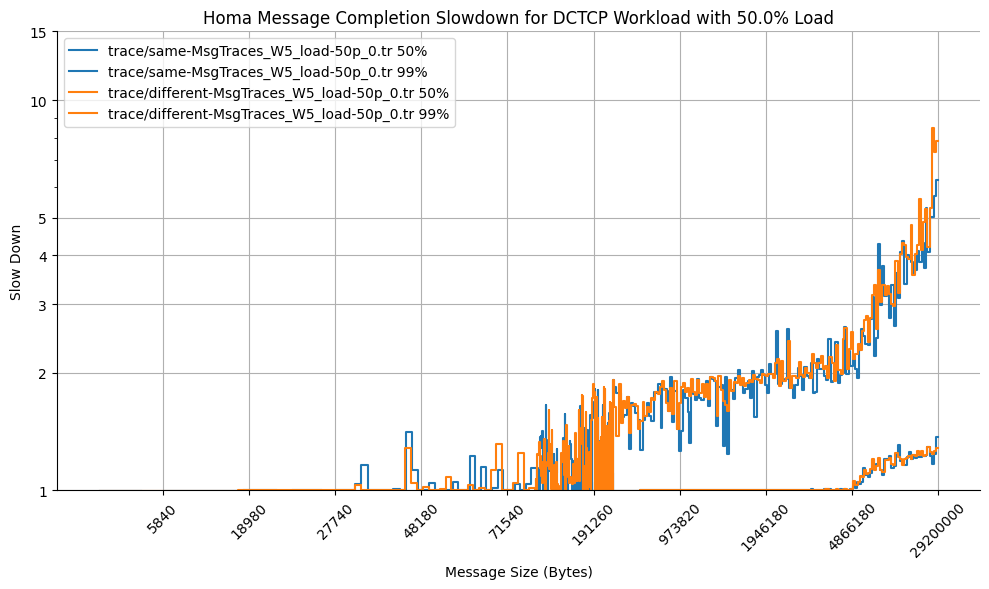

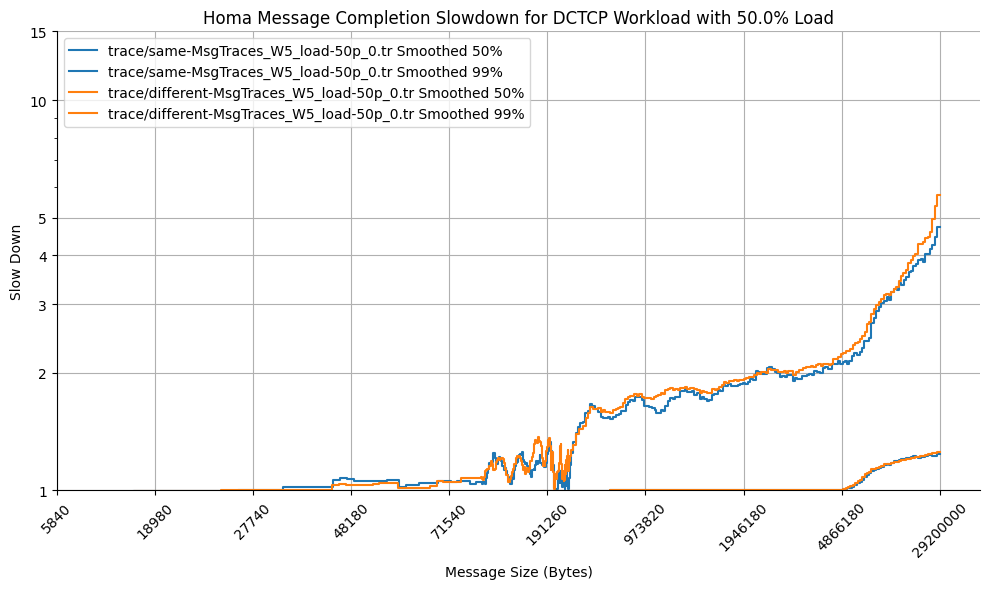


Getting Binned Means
trace/same-MsgTraces_W5_load-50p_0.tr
50th Percentile Mean:  1.0075140660991277
99th Percentile Mean:  1.5382076128242341
50th Percentile Mean (Binned):  [0.9398680546939591, 0.9845085172240584, 0.9907055806333617, 0.9934555219608082, 0.994826050298065, 0.9961002444382405, 0.9980473697977112, 0.999819995008982, 1.0018131725277493, 1.175996154408341]
99th Percentile Mean (Binned):  [1.0192035508503081, 1.1310604694851307, 1.1475187717178843, 1.1484089304572884, 1.059628284153155, 1.0567047351946777, 1.5257784828022074, 1.7797307261883826, 2.0199243635244217, 3.4941178138688826]

trace/different-MsgTraces_W5_load-50p_0.tr
50th Percentile Mean:  1.0081947677791943
99th Percentile Mean:  1.6156088880338333
50th Percentile Mean (Binned):  [0.9398680545656621, 0.984591303279134, 0.9909489916253168, 0.9934487180092028, 0.994989041667548, 0.9961543605475415, 0.9981286586777405, 0.9998100716818591, 1.0019149694678418, 1.1820935082700956]
99th Percentile Mean (Binned):  [1.

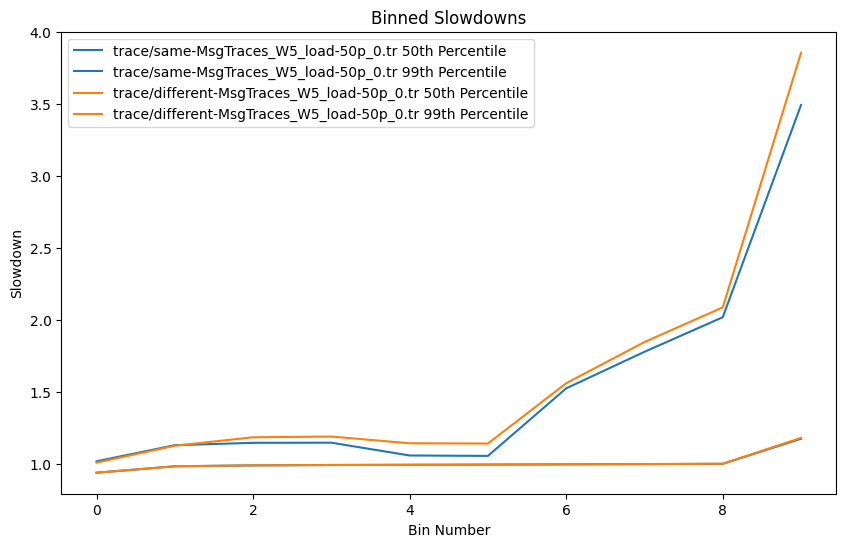

In [18]:
# filenames = ["trace/same-MsgTraces_W5_load-50p_0.tr", "trace/different-MsgTraces_W5_load-50p_0.tr"]
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

sim50slowdowns = {}
sim99slowdowns = {}

# Print metrics and plot unsmoothed plot
plt.figure(figsize=figsize)
plt.grid()
for i, filename in enumerate(filenames):
    print(filename)
    msgCompletionTimesDict, msgSizePercentiles, allMsgSizes = processFile(filename)
    print()

    SimMsgSizes, SimP50SlowDowns, SimP99SlowDowns = plot_data_v2(msgCompletionTimesDict, msgSizePercentiles, allMsgSizes, filename, colors[i])
    sim50slowdowns[filename] = SimP50SlowDowns
    sim99slowdowns[filename] = SimP99SlowDowns
plt.show()

# Plot just the smoothed plot
plt.figure(figsize=figsize)
plt.grid()
for i, filename in enumerate(filenames):
    msgCompletionTimesDict, msgSizePercentiles, allMsgSizes = processFile(filename, do_print=False)
    SimMsgSizes, SimP50SlowDowns, SimP99SlowDowns = plot_data_v2(msgCompletionTimesDict, msgSizePercentiles, allMsgSizes, filename, colors[i], plot_smoothed_results=True)
plt.show()

# Plot means and binned means
plt.figure(figsize=(10, 6))
print("\nGetting Binned Means")
for i, filename in enumerate(filenames):
    print(filename)
    bin_slowdowns(sim50slowdowns[filename], sim99slowdowns[filename], filename, colors[i])
    print()